In [1]:
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import yfinance as yf
from scipy.stats import gmean

# add utils path
src_path = os.path.abspath('../../')
if src_path not in sys.path:
    sys.path.append(src_path)

# import custom functions
from src.backtest import BacktestTrader
from src.strategies import EWMAC
from src.utils import get_risk_free_rate

In [2]:
START_DATE = '1999-01-21'
END_DATE = datetime.today().strftime('%Y-%m-%d')
TICKER = 'SPY'

SHORT_WINDOW = 16
LONG_WINDOW = 64

prices = yf.download(TICKER, start=START_DATE, end=END_DATE)['Adj Close']
risk_free_rate = get_risk_free_rate(START_DATE, END_DATE)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


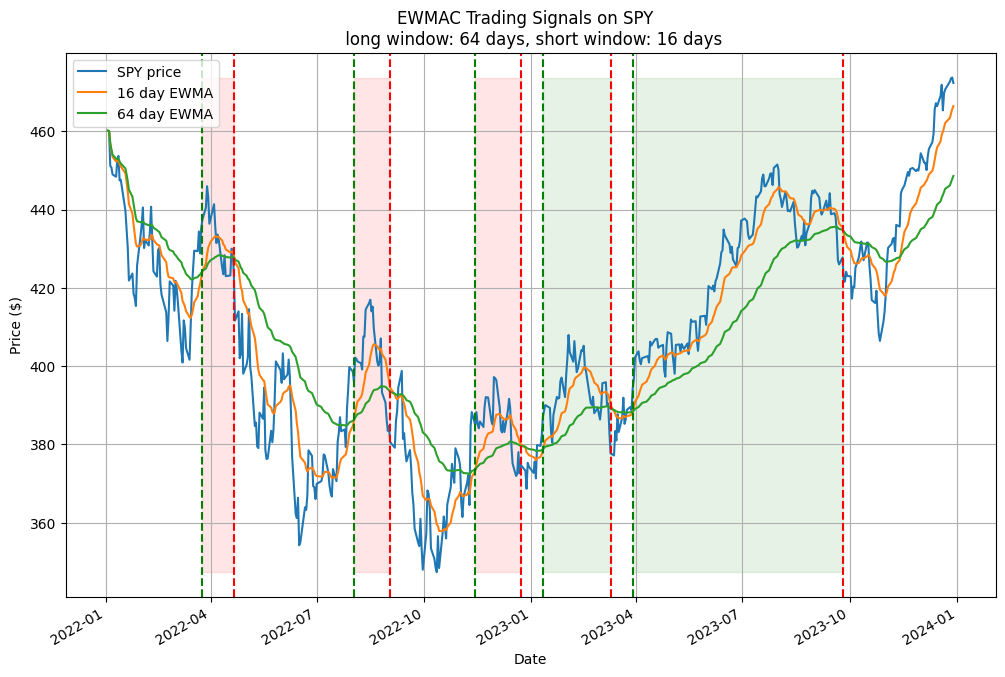

In [3]:
# example of EWMA crossover strategy
ex_data = yf.download(TICKER, start='2022-01-01', end='2023-12-31')['Adj Close']
ewma_short = ex_data.ewm(span=SHORT_WINDOW).mean()
ewma_long = ex_data.ewm(span=LONG_WINDOW).mean()

# find the crossovers
ewma_diff = ewma_short - ewma_long
crossovers = np.where(np.diff(np.sign(ewma_diff)))[0]
if ewma_diff.iloc[crossovers[1]] < 0:
    crossovers = crossovers[1:]
# add a final crossover if the last signal was a buy
if len(crossovers) % 2 == 0:
    crossovers = np.append(crossovers, len(ex_data)-1)

plt.figure(figsize=(12, 8))
plt.plot(ex_data, label=f'{TICKER} price')
ewma_short.plot(label=f'{SHORT_WINDOW} day EWMA')
ewma_long.plot(label=f'{LONG_WINDOW} day EWMA')

# plot trade windows
y_limits = [ex_data.min(), ex_data.max()]
for n in range(0, len(crossovers)-1, 2):
    plt.axvline(ex_data.index[crossovers[n]], color='g', linestyle='--')
    plt.axvline(ex_data.index[crossovers[n+1]], color='r', linestyle='--')
    
    shade_color = 'green' if ex_data.iloc[n+1] > ex_data.iloc[n] else 'red'
    plt.fill_betweenx(
        y_limits, ex_data.index[crossovers[n]],
        ex_data.index[crossovers[n+1]],
        color=shade_color,
        alpha=0.1
    )
    
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'EWMAC Trading Signals on {TICKER}  \n long window: {LONG_WINDOW} days, short window: {SHORT_WINDOW} days')
plt.legend()
plt.grid()
plt.show()

In [4]:
stock_returns = prices.pct_change().dropna()
total_returns = (prices.iloc[-1]-prices.iloc[0])/prices.iloc[0]
average_returns = gmean(np.array(stock_returns)+1)-1
annual_returns = (1+average_returns)**252 - 1
annual_std = np.std(stock_returns) * np.sqrt(252)
sharpe_ratio = (annual_returns - risk_free_rate.mean()) / annual_std

stock_results = {
    'total_returns': total_returns,
    'average_returns': average_returns,
    'annual_returns': annual_returns,
    'annual_std': annual_std,
    'sharpe_ratio': sharpe_ratio
}

In [5]:
print(f'Holding {TICKER}')
stock_results

Holding SPY


{'total_returns': 6.324122530550579,
 'average_returns': 0.0003084219299458457,
 'annual_returns': 0.08080954946291596,
 'annual_std': 0.1939413948825351,
 'sharpe_ratio': 0.24388558590772047}

In [6]:
ewmac = EWMAC(short_window=SHORT_WINDOW, long_window=LONG_WINDOW)
ewmac_trader = BacktestTrader(ewmac, prices)
ewmac_trader.run_backtest()
ewmac_results = ewmac_trader.get_results()

In [7]:
print(f'Trading {TICKER} with EWMAC (no shorting)')
ewmac_results

Trading SPY with EWMAC (no shorting)


{'average_returns': 0.00021238895196762364,
 'annual_returns': 0.054974222476603885,
 'annual_std': 0.11592307024576413,
 'sharpe_ratio': 0.1851640650922219,
 'total_returns': 2.9402723640441892,
 'portfolio_value': 39402.723640441895}

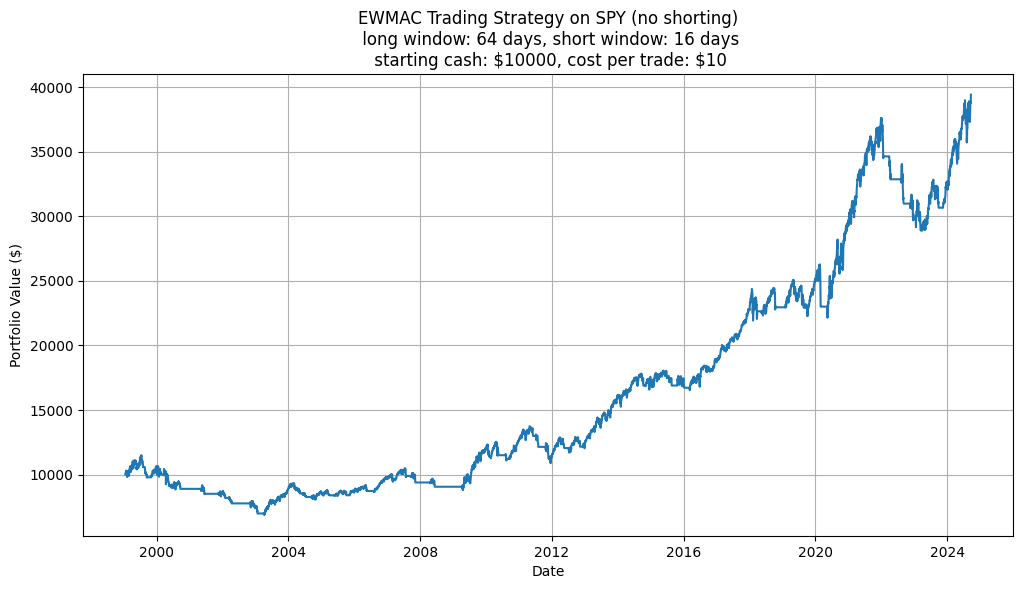

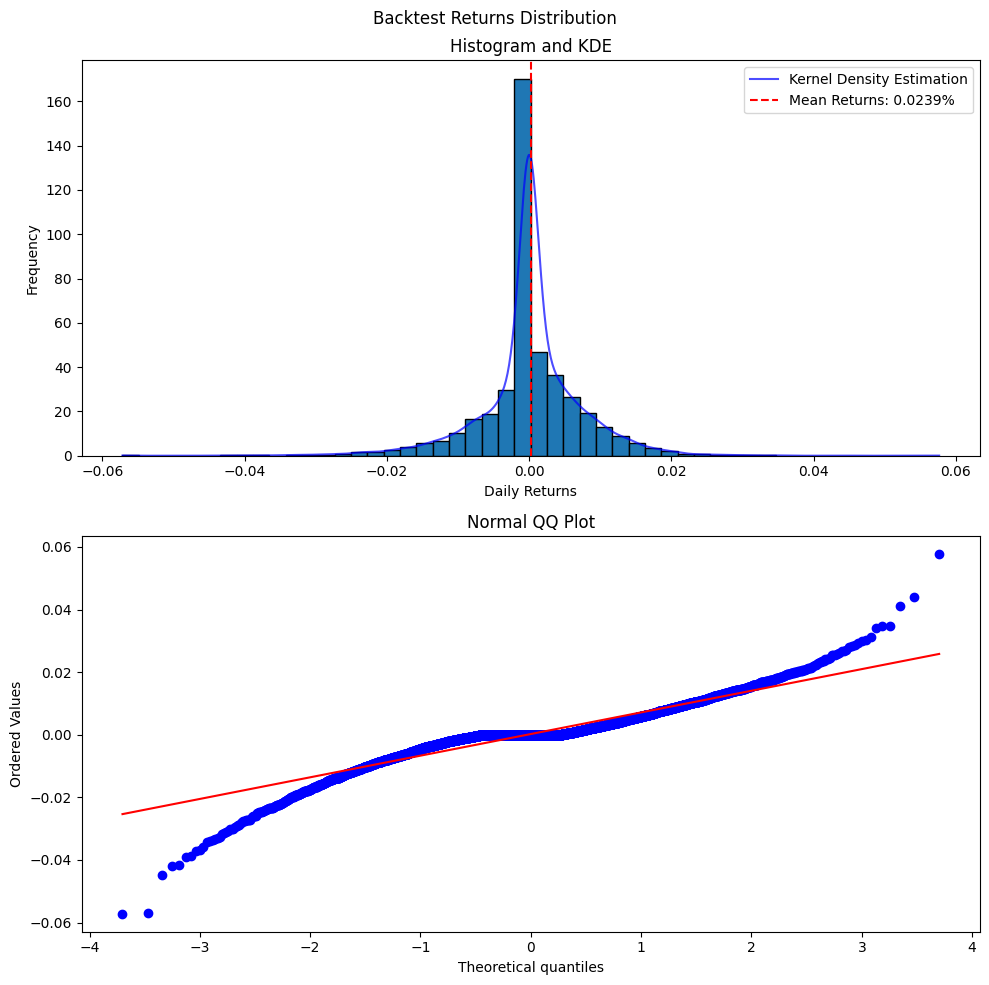

In [8]:
ewmac_trader.plot_results(
    title=(
        f'EWMAC Trading Strategy on {TICKER} (no shorting)' +
        f'\n long window: {LONG_WINDOW} days, short window: {SHORT_WINDOW} days' +
        f'\n starting cash: \$10000, cost per trade: \$10'
    )
)
ewmac_trader.plot_analysis()

In [9]:
ewmac_short = EWMAC(short_window=SHORT_WINDOW, long_window=LONG_WINDOW, enable_shorting=True)
ewmac_short_trader = BacktestTrader(ewmac_short, prices)

ewmac_short_trader.run_backtest()
ewmac_short_results = ewmac_short_trader.get_results()

In [10]:
print(f'Trading {TICKER} with EWMAC (shorting enabled)')
ewmac_short_results

Trading SPY with EWMAC (shorting enabled)


{'average_returns': 4.701697231390689e-05,
 'annual_returns': 0.011918464047899091,
 'annual_std': 0.16872448925596958,
 'sharpe_ratio': -0.12796584300973965,
 'total_returns': 0.3547019317246704,
 'portfolio_value': 13547.019317246704}

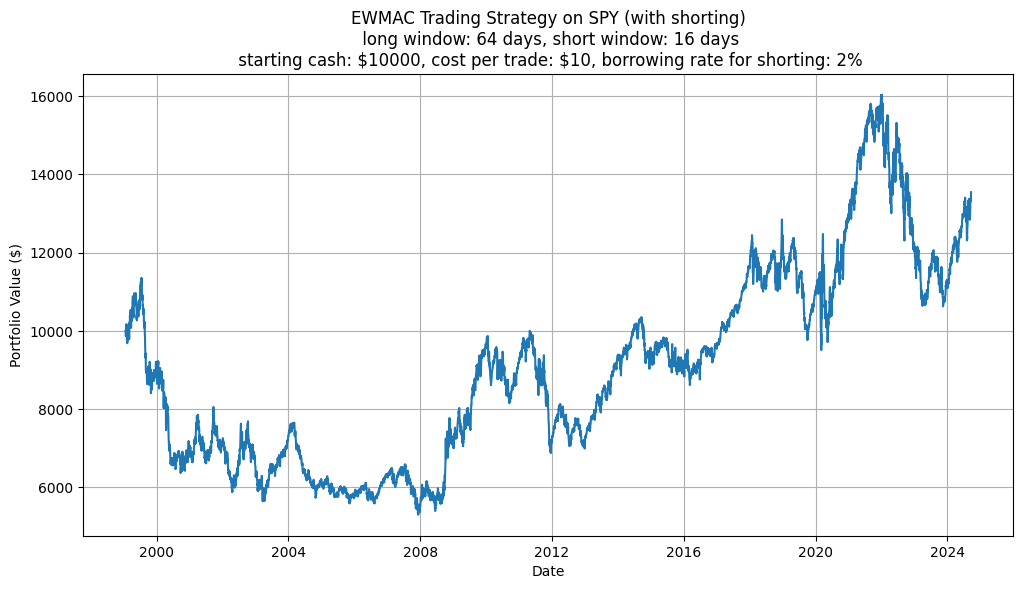

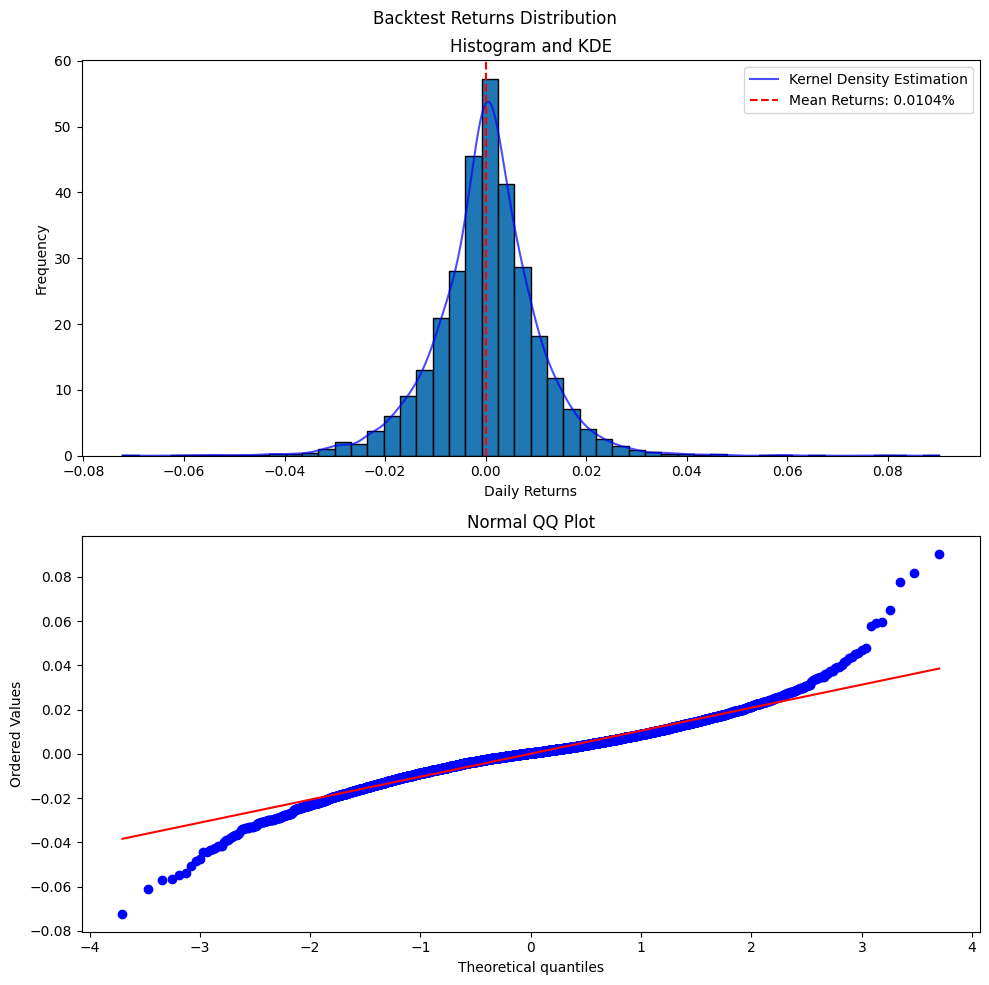

In [11]:
ewmac_short_trader.plot_results(
    title=(
        f'EWMAC Trading Strategy on {TICKER} (with shorting)' +
        f'\n long window: {LONG_WINDOW} days, short window: {SHORT_WINDOW} days'
        f'\n starting cash: \$10000, cost per trade: \$10, borrowing rate for shorting: 2%'
    )
)
ewmac_short_trader.plot_analysis(hist_bins=50)

In [23]:
# stationary bootstrap
historical_returns = prices.pct_change().dropna()
data_len = len(historical_returns)
n_iterations = 100
exp_block_len = 10
bootstrap_samples = []
sample_stats = {}

for _ in range(n_iterations):
    sample = []
    i = np.random.randint(0, data_len)
    
    while len(sample) < data_len:
        sample.append(historical_returns.iloc[i])
        
        if np.random.rand() < 1/exp_block_len:
            i = np.random.randint(0, data_len) # sample a new block
        else:
            i = (i+1) % data_len # sample next data point in block
    
    # calculate statistics for sample
    average_returns = gmean(np.array(sample)+1)-1
    annual_returns = (1+average_returns)**252 - 1
    annual_std = np.std(sample) * np.sqrt(252)
    sharpe_ratio = (annual_returns - risk_free_rate.mean()) / annual_std
    
    sample_stats.setdefault('mean returns', []).append(average_returns)
    sample_stats.setdefault('annual returns', []).append(annual_returns)
    sample_stats.setdefault('annual std', []).append(annual_std)
    sample_stats.setdefault('sharpe ratio', []).append(sharpe_ratio)
    
    bootstrap_samples.append(np.array(sample))

# calculate bootstrap statistics
bootstrap_stats = pd.DataFrame(index=['mean', 'median', 'std', '95 upper', '95 lower'])
for key, value in sample_stats.items():
    ci = np.percentile(value, [2.5, 97.5])
    bootstrap_stats.loc['mean', key] = np.mean(value)
    bootstrap_stats.loc['median', key] = np.median(value)
    bootstrap_stats.loc['std', key] = np.std(value)
    bootstrap_stats.loc['95 lower', key] = ci[0]
    bootstrap_stats.loc['95 upper', key] = ci[1]

In [24]:
bootstrap_stats.T

,mean,median,std,95 upper,95 lower
mean returns,0.000285,0.000288,0.000131,0.000519,0.000019
annual returns,0.075086,0.075349,0.035465,0.139623,0.004680
annual std,0.193009,0.192923,0.009896,0.211264,0.176285
sharpe ratio,0.219395,0.219140,0.189707,0.561403,-0.152440


In [25]:
# reconstruct price time series and calculate statistics
initial_price = prices.iloc[0]
bootstrap_prices = []
for sample in bootstrap_samples:
    sample_prices = [initial_price]
    sample_prices.extend(initial_price * (1+sample).cumprod())
    
    bootstrap_prices.append(sample_prices)

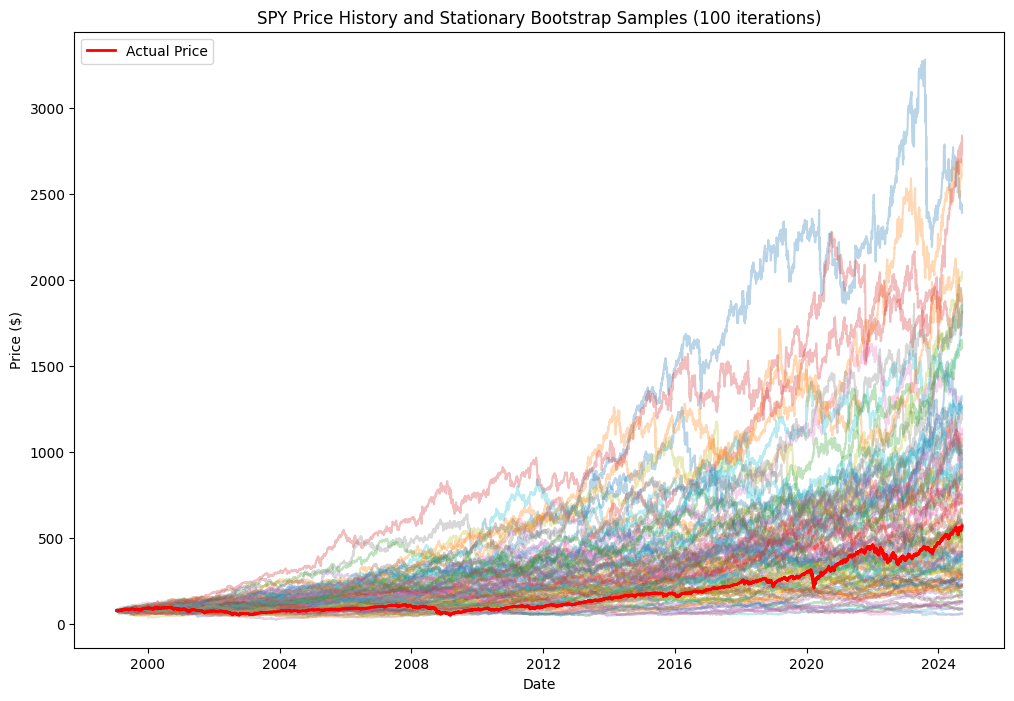

In [26]:
dates = prices.index

# plot
plt.figure(figsize=(12, 8))

for sample in bootstrap_prices:
    plt.plot(dates, sample, alpha=0.3)

plt.plot(prices, label=f'Actual Price', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{TICKER} Price History and Stationary Bootstrap Samples ({n_iterations} iterations)')
plt.legend()
plt.show()

In [16]:
bootstrap_results = ewmac_trader.run_bootstrap(block_size=10)

In [17]:
bootstrap_results

,mean,median,std,95 upper,95 lower
average_returns,0.000162,0.000161,0.000067,0.000289,0.000034
annual_returns,0.041805,0.041458,0.017507,0.075425,0.008643
annual_std,0.150640,0.151488,0.010220,0.167365,0.128666
sharpe_ratio,0.057303,0.052653,0.119099,0.295439,-0.167268


In [18]:
ewmac_results

{'average_returns': 0.00021238895196762364,
 'annual_returns': 0.054974222476603885,
 'annual_std': 0.11592307024576413,
 'sharpe_ratio': 0.1851640650922219,
 'total_returns': 2.9402723640441892,
 'portfolio_value': 39402.723640441895}